In [1]:
# # Setup
# ! sudo apt install -y libgl1-mesa-glx libglib2.0-0 libsm6 libxrender1 libxext6
# ! pip install open-iris==1.0.0 faiss-cpu seaborn

# Imports

In [ ]:
import os
import pickle
import shutil
import sys
import threading
import time
from datetime import datetime
from functools import reduce
from io import BytesIO
from itertools import combinations, product
from operator import mul

In [ ]:
import boto3
import iris
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import psutil
import scipy
import seaborn as sns
from joblib import Parallel, delayed
from scipy.spatial.distance import hamming, pdist
from scipy.stats import ks_2samp, ttest_ind

In [ ]:
import hnsw
from iris.io.dataclasses import IrisTemplate
from iris_integration import (
    iris_with_noise,
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
    int_distance
)
from iris_pairwise_min_dist_calculation import get_pairwise_min_dist_across_rotations

In [5]:
n_jobs = 6 # Fit to CPU
DIM = (2, 32, 200)
X, Y = DIM [1:]
MAX_ROT = 15

In [6]:
last_update_time = time.time()
def print_progress(msg, delay=1):
    global last_update_time
    if time.time() - last_update_time > delay:
        sys.stdout.write('\r' + ' ' * (shutil.get_terminal_size().columns - 1))
        sys.stdout.write(f"\r{msg}")
        sys.stdout.flush()
        
        last_update_time = time.time()

def save_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)
    print(f"Object successfully saved to {filename}")

def load_pickle(filename):
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    print(f"Object successfully loaded from {filename}")
    return obj

# Data Loading

## Real Irises

In [7]:
shape = (16, 200)
# DEV = "-dev" # Access test data.
DEV = "" # Access real data.
print("Working on simulated data" if DEV else "Working on real data")

Working on real data


In [8]:
bucket_name = 'wld-inversed-data-sharing' + DEV
role_arn = 'arn:aws:iam::387760840988:role/worldcoin-data' + DEV
metadata_path = 'metadata.csv'

def memoize(func):
    cache = {}
    def memoized_func(*args):
        if args in cache:
            return cache[args]
        result = func(*args)
        cache[args] = result
        return result
    return memoized_func

def assume_role(role_arn, session_name="S3ReadSession"):
    sts_client = boto3.client('sts')
    assumed_role_object = sts_client.assume_role(
        RoleArn=role_arn,
        RoleSessionName=session_name
    )
    credentials = assumed_role_object['Credentials']
    s3 = boto3.client(
        's3',
        aws_access_key_id=credentials['AccessKeyId'],
        aws_secret_access_key=credentials['SecretAccessKey'],
        aws_session_token=credentials['SessionToken']
    )
    return s3

# Assume the role and get credentials
s3 = assume_role(role_arn, "S3ReadSession")

def read_s3_file(bucket_name, file_key):
    obj = s3.get_object(Bucket=bucket_name, Key=file_key)
    return BytesIO(obj['Body'].read())

@memoize
def load_response(image_id):
    " Return IrisFilterResponse "
    path = "iris_filter_responses/" + image_id + ".pickle"
    try:
        pkl_file = read_s3_file(bucket_name, path)
        return pickle.load(pkl_file)
    except Exception as err:
        print(err)
        return None

@memoize
def load_template(image_id):
    " Return IrisTemplate "
    path = "iris_templates/" + image_id + ".pickle"
    try:
        pkl_file = read_s3_file(bucket_name, path)
        return pickle.load(pkl_file)
    except Exception as err:
        print(err)
        return None

# Read the file into a DataFrame
meta = pd.read_csv(read_s3_file(bucket_name, metadata_path))

# Data Processing

## Real Irises

### Functions

In [13]:
# Helpers for iterators.
def take(count, it):
    " Take at most `count` items from the iterator `it` "
    for x in it:
        if count is not None:
            if count <= 0:
                break
            count -= 1
        yield x

In [14]:
# Load matching pairs.
def iter_matching_image_ids(meta, unique_subjects):
    " Iterate matching pairs in the form (subject_id, ir_image_id_0, ir_image_id_1). "
    subject_ids = meta["subject_id"].unique()

    for side in [0, 1]:
        meta_side = meta[meta["biological_side"] == side]

        for subject in subject_ids:
            signups = meta_side[meta_side["subject_id"] == subject]
            if len(signups) < 2:
                continue

            L = 2 if unique_subjects else len(signups)

            for i in range(L - 1):
                for j in range(i + 1, L):
                    yield (f"{subject}_side{side}", signups["ir_image_id"].iloc[i], signups["ir_image_id"].iloc[j])

def load_matching_image_ids(meta, unique_subjects):
    " Return matching pairs in the form (subject_id, ir_image_id_0, ir_image_id_1), shuffled. "    
    pair_image_ids = list(iter_matching_image_ids(meta, unique_subjects))
    rng = np.random.default_rng(seed=12345)
    rng.shuffle(pair_image_ids)
    return pair_image_ids

def iter_related_pairs(meta, unique_subjects):
    " Iterate matching pairs in the form (subject_id, response_0, response_1). "
    for (subject, img_i, img_j) in load_matching_image_ids(meta, unique_subjects):
        res_i = load_response(img_i)
        res_j = load_response(img_j)
        if res_i and res_j:
            yield (subject, res_i, res_j)

def load_related_pairs(meta, count=None, unique_subjects=False):
    " Return matching pairs in the form (subject_id, response_0, response_1). "
    return list(take(count, iter_related_pairs(meta, unique_subjects)))

In [15]:
# Masking methodologies
def fill_masked_with_random(bits, mask):
    filler = np.random.randint(0, 2, size=bits.shape, dtype=bool)
    filler &= not_(mask)
    bits ^= filler

def fill_masked_with_zeros(bits, mask):
    bits &= mask

# Techniques that do not support masking will work, although with a modified scale of distances.
# The change in distance can be calculated from the size of the overlap of masks. Alternatively,
# it can be estimated with the expected average of that.

In [16]:
# Make encoders from parameters.
def make_encoder(v_subsample=1, h_subsample=1, top=True, bottom=True, real=True, imag=True, mask_threshold=0.9, static_mask=None, mask_with_random=False):

    res_indexes = (top and [0] or []) + (bottom and [1] or [])
    assert res_indexes, "require top, bottom, or both"

    quantizers = (real and [np.real] or []) + (imag and [np.imag] or [])
    assert quantizers, "require real, imag, or both"
    
    def encode(response):
        bit_parts = []
        mask_parts = []
        
        for res_index in res_indexes:
            for quantizer in quantizers:
                res = response.iris_responses[res_index][::v_subsample, ::h_subsample]
                bits = quantizer(res) > 0
                mask = response.mask_responses[res_index][::v_subsample, ::h_subsample] >= mask_threshold

                if mask_with_random:
                    # Replace masked bits with random bits.
                    fill_masked_with_random(bits, mask)
                
                if static_mask is not None:
                    # Remove the bits not selected by the static mask.
                    fill_masked_with_zeros(bits, static_mask[::v_subsample, ::h_subsample])
                    # Treat non-selected bits as masked (False).
                    mask &= static_mask[::v_subsample, ::h_subsample]
                
                bit_parts.append(bits)
                mask_parts.append(mask)
                assert mask.shape == bits.shape

        return np.concatenate(bit_parts), np.concatenate(mask_parts)
    
    return encode

def encode_pairs(pairs, encode_fn):
    return [
        (subject_id, encode_fn(response_a), encode_fn(response_b))
        for subject_id, response_a, response_b in pairs
    ]

In [17]:
# Distances
def masked_distance(x, x_mask, y, y_mask):
    mask = x_mask & y_mask
    hd = np.sum((x ^ y) & mask)
    return hd / np.sum(mask)

def masked_rotate(x, rotation):
    return (
        np.roll(x[0], rotation, axis=1),
        np.roll(x[1], rotation, axis=1),
    )

def distance(x, y):
    return masked_distance(x[0], x[1], y[0], y[1])

def distance_raw(raw_x, raw_y):
    return distance(encode_high(raw_x), encode_high(raw_y))

def rotate_raw(raw_x, rotation):
    iris_responses = [
        np.roll(r, rotation, axis=1)
        for r in raw_x.iris_responses
    ]
    mask_responses = [
        np.roll(r, rotation, axis=1)
        for r in raw_x.mask_responses
    ]
    return iris.IrisFilterResponse(iris_responses=iris_responses, mask_responses=mask_responses)

In [18]:
# Rotations.
def without_rotation(pairs, distance_fn, rotate_fn, max_rotation):
    for subject_id, x, y in pairs:
        distances = [
            distance_fn(x, rotate_fn(y, rotation))
            for rotation in range(-max_rotation, max_rotation+1)
        ]
        best_rotation = -max_rotation + np.argmin(distances)        
        y_aligned = rotate_fn(y, best_rotation)
        yield (subject_id, x, y_aligned)

def remove_rotation(pairs, distance_fn=distance, rotate_fn=masked_rotate, max_rotation=15):
    return list(without_rotation(pairs, distance_fn, rotate_fn, max_rotation))

In [19]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

### Loading

In [20]:
# 6 min
encode_high = make_encoder()
related_pairs = load_related_pairs(meta, count=None, unique_subjects=False)
related_pairs_norot = remove_rotation(related_pairs, distance_fn=distance_raw, rotate_fn=rotate_raw)
related_pairs_high = encode_pairs(related_pairs_norot, encode_high)
shape_high = related_pairs_high[0][1][0].shape
print(f"Finished loading {len(related_pairs_high)} pairs,", "High-res", shape_high, np.prod(shape_high), "bits")

An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified 

In [21]:
tuples_array = np.array(related_pairs_high, dtype=object)
subject_ids = np.repeat(tuples_array[:, 0], 2)  # Repeat each subject_id twice
flattened_result = [item for tup in tuples_array for item in tup[1:]]
iris_matrices, mask_matrices = zip(*flattened_result)

In [22]:
true_iris_df = pd.DataFrame({
    'subject_id': subject_ids,
    'iris_matrices': iris_matrices,
    'mask_matrices': mask_matrices
})
true_iris_df['side'] = true_iris_df['subject_id'].apply(lambda x: x[-1])
true_iris_df['subject_id'] = true_iris_df['subject_id'].apply(lambda x: x.split('_')[0])

In [23]:
# Dropping duplicates
true_iris_df['iris_matrices_bytes'] = true_iris_df['iris_matrices'].apply(lambda matrix: matrix.tobytes())
true_iris_df['mask_matrices_bytes'] = true_iris_df['mask_matrices'].apply(lambda matrix: matrix.tobytes())
true_iris_df = (
    true_iris_df
    .drop_duplicates(subset=['subject_id', 'iris_matrices_bytes', 'mask_matrices_bytes'])
    .drop(columns=['iris_matrices_bytes', 'mask_matrices_bytes'])
    .reset_index(drop=True)
)
print(f'Final iris DataFrame contains {len(true_iris_df)} unique samples')

Final iris DataFrame contains 6307 unique samples


In [24]:
unique_true_iris_df = true_iris_df.drop_duplicates(subset=['subject_id', 'side'])
print(f'Unique iris DataFrame contains {len(unique_true_iris_df)} samples')

Unique iris DataFrame contains 312 samples


# Various Experiments

## Derive real iris pairwise distance std

In [25]:
irises = np.stack(unique_true_iris_df['iris_matrices'])
masks = np.stack(unique_true_iris_df['mask_matrices'])

In [64]:
def majority_vote_reduction(matrices_array, new_dim):
    if ((X % new_dim[0]) != 0) or ((Y % new_dim[1]) != 0):
        raise ValueError("X must divide 64 and Y must divide 200 evenly.")
    
    new_rows = (X // new_dim[0]) * 2
    new_cols = Y // new_dim[1]

    reshaped = matrices_array.reshape(matrices_array.shape[0], new_rows, new_dim[0], new_cols, new_dim[1])
    reshaped = reshaped.swapaxes(2, 3)
    return np.mean(reshaped, axis=(3, 4)) > 0.5

In [100]:
dims_results = dict()
for dims in [1,2,4,8]: 
    reshaped_irises = majority_vote_reduction(irises, (dims,dims))
    reshaped_masks = majority_vote_reduction(masks, (dims,dims))
    dims_results[f'({dims}, {dims})'] = get_pairwise_min_dist_across_rotations(iris_matrices=reshaped_irises, mask_matrices=reshaped_masks, max_rotation=0)
scatter_plot_df = pd.DataFrame(dims_results)
hist_plot_df = scatter_plot_df.melt(var_name='New Pixel Dimensions', value_name='Pairwise Distance')

<Axes: xlabel='(1, 1)', ylabel='(8, 8)'>

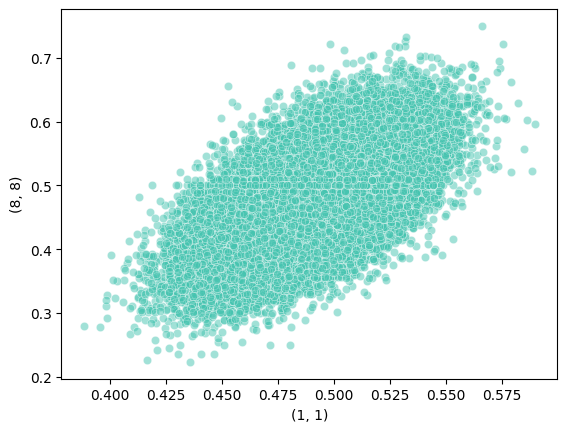

In [104]:
sns.scatterplot(scatter_plot_df, x='(1, 1)', y='(8, 8)', alpha=0.5, color='#45C4B0')

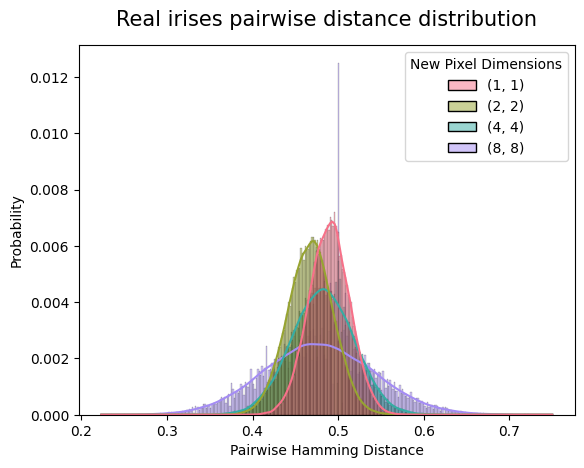

In [105]:
sns.histplot(hist_plot_df, x='Pairwise Distance', hue='New Pixel Dimensions', palette='husl', stat='probability', kde=True)
plt.title('Real irises pairwise distance distribution', fontsize=15, y=1.03)
plt.xlabel('Pairwise Hamming Distance')
plt.show()

## Progress in random iris direction

### Configurations

In [45]:
num_unique_samples = len(unique_true_iris_df)
unique_irises = np.stack(unique_true_iris_df['iris_matrices'].tolist())
N = 1000
thres = 0.05
M = 64

### Thres test

In [47]:
first_exceeding_ranks = []
for _ in range(N):
    # Select two random samples and flatten them
    idx = np.random.choice(num_unique_samples, 2, replace=False)
    origin, target = unique_irises[idx[0]].flatten(), unique_irises[idx[1]].flatten()

    # Sort and take all other samples
    remaining_indices = np.array([i for i in range(num_unique_samples) if i not in idx])
    remaining_samples = unique_irises[remaining_indices].reshape(-1, origin.size)
    sorted_indices = np.argsort(np.mean(origin != remaining_samples, axis=1))

    # Compare distances
    origin_to_target_dist = np.mean(origin != target) 
    dist_to_target = np.mean(remaining_samples[sorted_indices] != target, axis=1)
    dist_diff = origin_to_target_dist - dist_to_target
    exceeding_indices = np.where(dist_diff > thres)[0]
    first_exceeding_ranks.append(exceeding_indices[0]+1 if exceeding_indices.size > 0 else np.inf)

In [50]:
thres_not_reached_percentage = np.isinf(first_exceeding_ranks).mean()

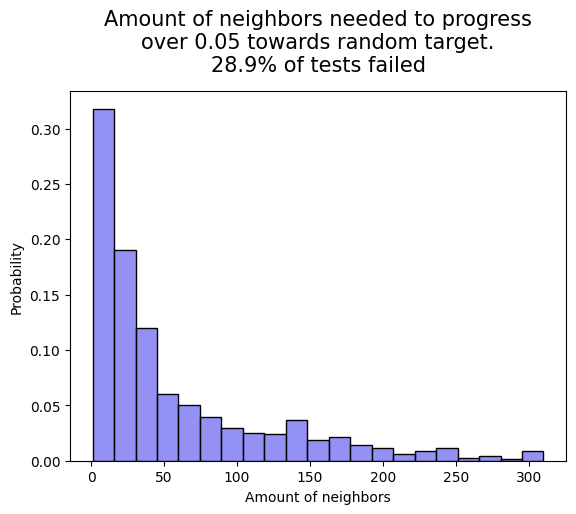

In [57]:
sns.histplot(first_exceeding_ranks, color='#716DF2', stat='probability')
plt.title(f'Amount of neighbors needed to progress\nover {thres} towards random target.\n{thres_not_reached_percentage:.1%} of tests failed', fontsize=15, y=1.03)
plt.xlabel('Amount of neighbors')
plt.show()

### M test

In [59]:
largest_distances_lst = []
for _ in range(N):
    # Select two random samples and flatten them
    idx = np.random.choice(num_unique_samples, 2, replace=False)
    origin, target = unique_irises[idx[0]].flatten(), unique_irises[idx[1]].flatten()

    # Sort and take all other samples
    remaining_indices = np.array([i for i in range(num_unique_samples) if i not in idx])
    remaining_samples = unique_irises[remaining_indices].reshape(-1, origin.size)
    sorted_indices = np.argsort(np.mean(origin != remaining_samples, axis=1))

    # Average progress calculation
    origin_to_target_dist = np.mean(origin != target)
    dist_to_target = np.mean(remaining_samples[sorted_indices][:M,:] != target, axis=1).min()
    largest_distances_lst.append(origin_to_target_dist - dist_to_target)

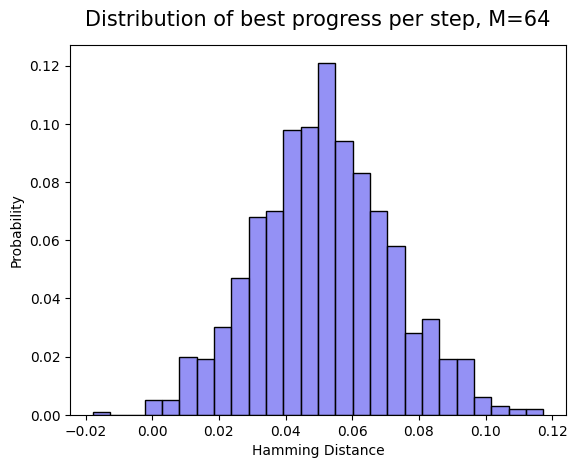

In [62]:
sns.histplot(largest_distances_lst, color='#716DF2', stat='probability')
plt.title(f'Distribution of best progress per step, M={M}', fontsize=15, y=1.03)
plt.xlabel('Hamming Distance')
plt.show()

## Weighted iris pairwise distance

In [ ]:
def weighted_hamming(arr, k=2):
    weights = np.nan_to_num(np.abs(arr - 0.5) ** k)
    return np.average(arr, weights=weights)

def reshape_for_weighted_hamming(arr, vertical_sections, section_height, num_strips, strip_size):
    return [
        arr[i].reshape(vertical_sections, section_height, num_strips, strip_size)
        for i in range(2)
    ]

def compute_weighted_hamming_distance(iris_matrices, mask_matrices, strip_size):
    num_strips = Y // strip_size
    vertical_sections = 4
    section_height = reduce(mul, DIM[:2]) // vertical_sections

    reshaped_iris_matrices = reshape_for_weighted_hamming(iris_matrices, vertical_sections, section_height, num_strips, strip_size)
    reshaped_mask_matrices = reshape_for_weighted_hamming(mask_matrices, vertical_sections, section_height, num_strips, strip_size)
    combined_masks = np.logical_and(reshaped_mask_matrices[0], reshaped_mask_matrices[1])

    valid_elements_count = np.sum(combined_masks, axis=(1, 3))
    differences = np.sum((reshaped_iris_matrices[0] != reshaped_iris_matrices[1]) & combined_masks, axis=(1, 3))
    hamming_distances = np.where(valid_elements_count > 0, differences / valid_elements_count, np.nan).flatten()

    return weighted_hamming(hamming_distances)

def hamming_distance_with_masks(iris_matrices, mask_matrices):
    combined_mask = np.logical_and(mask_matrices[0], mask_matrices[1])
    differences = (iris_matrices[0] != iris_matrices[1]) & combined_mask
    return np.sum(differences) / np.sum(combined_mask)

In [ ]:
irises = np.stack(unique_true_iris_df['iris_matrices'])
masks = np.stack(unique_true_iris_df['mask_matrices'])

In [ ]:
hamming_distances, weighted_hamming_distances = [], []
for i, (idx1, idx2) in enumerate(combinations(range(len(unique_true_iris_df)), 2)):
    print_progress(f'Calculation progress: {(i+1)/math.comb(len(unique_true_iris_df), 2):.1%}')
    hamming_distances.append(hamming_distance_with_masks(irises[[idx1,idx2]], masks[[idx1,idx2]]))
    weighted_hamming_distances.append(compute_weighted_hamming_distance(irises[[idx1,idx2]], masks[[idx1,idx2]], 20))

In [ ]:
results = pd.DataFrame({
    'Hamming Distance':hamming_distances, 
    'Weighted Hamming Distance':weighted_hamming_distances,
})

In [ ]:
sns.scatterplot(results, x='Hamming Distance', y='Weighted Hamming Distance', alpha=0.5, color='#45C4B0');

## Synthetic irises - HNSW database & Search Analysis

### Functions and data loading

In [7]:
def int_to_scaled_string(n):
    suffixes = ['', 'K', 'M', 'B', 'T']
    idx = max(0, min(len(suffixes) - 1, int((len(str(abs(n))) - 1) / 3)))
    scaled = n / (1000 ** idx)
    return f"{scaled:.1f}{suffixes[idx]}" if scaled % 1 else f"{int(scaled)}{suffixes[idx]}"

In [8]:
def read_partial_file(filename, num_bits):
    num_bytes = (num_bits + 7) // 8  # Ensure we round up if num_bits isn't a multiple of 8
    with open(filename, 'rb') as f:
        chunk = f.read(num_bytes)
    return np.frombuffer(chunk, dtype=np.uint8)

In [9]:
def load_and_reshape_masks(filename, num_masks):
    flattened_data = np.unpackbits(read_partial_file(filename, ((X//2) * Y) * num_masks))
    boolean_arrays = flattened_data.reshape((num_masks, X//2, Y))
    vertically_stacked = np.tile(boolean_arrays, (1, 2, 1))
    duplicated_arrays = np.repeat(vertically_stacked[:, np.newaxis, :, :], DIM[0], axis=1)
    return duplicated_arrays

In [10]:
def import_voter_model_rust_implementation(path_low, path_high, num_samples, DIM=DIM):
    low_high_lst = [
        np.unpackbits(
            read_partial_file(path, ((X * Y) * num_samples)), bitorder="little"
        ).reshape(num_samples, *DIM[1:]) for path in [path_low, path_high]
    ]
    return np.concatenate(low_high_lst, axis=1).astype(bool)

In [11]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [12]:
read_num = 100000
total_num_masks = 2**22
path = f'{int_to_scaled_string(total_num_masks)}_mask_arrays.dat'
path_low = '2_23_voter_arrays_90k_b090.dat'
path_high = '2_23_voter_arrays_14k_b010.dat'

In [13]:
loaded_masks = load_and_reshape_masks(path, read_num).astype(bool).reshape(read_num, reduce(mul, DIM))

In [14]:
loaded_irises = import_voter_model_rust_implementation(path_low, path_high, read_num).reshape(read_num, reduce(mul, DIM))

### Synthetic Pairwise Distances

In [41]:
num_experiments = 200
batch_size = 100

In [56]:
all_distances = []
for i in range(num_experiments):
    print_progress(f'Hamming Distances Calculation Progress: {(i+1)/(num_experiments+1):.1%}')
    indices = np.random.choice(read_num, size=batch_size, replace=False)
    valid_positions = np.expand_dims(loaded_masks[indices], axis=1) & np.expand_dims(loaded_masks[indices], axis=0)
    differences = np.expand_dims(loaded_irises[indices], axis=1) != np.expand_dims(loaded_irises[indices], axis=0)
    hamming_distances = np.sum(differences & valid_positions, axis=-1) / np.sum(valid_positions, axis=-1)
    all_distances.extend(hamming_distances[hamming_distances > 0])

Hamming Distances Calculation Progress: 99.5%

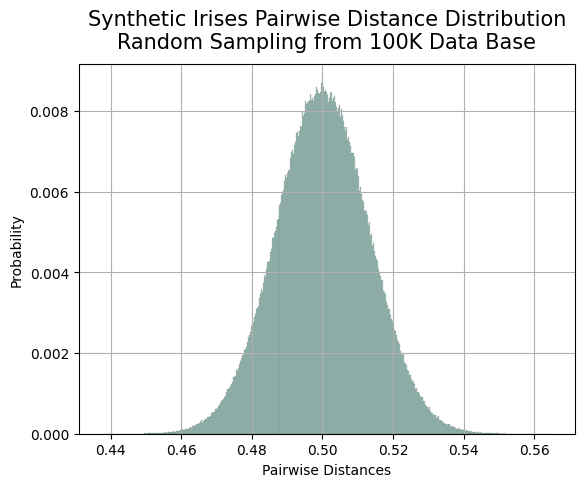

In [62]:
sns.histplot(pd.Series(all_distances, name='Pairwise Distances'), color='#8CBEB2', stat='probability')
plt.grid()
plt.title('Synthetic Irises Pairwise Distance Distribution\nRandom Sampling from 100K Data Base', fontsize=15, y=1.02)
plt.show()

In [82]:
N = 1000
Z_points = np.array(np.meshgrid(np.arange(-N, N + 1), np.arange(-N, N + 1))).T.reshape(-1, 2)

In [96]:
num_experiments = 500
batch_size = 100

In [97]:
all_distances = []
for i in range(num_experiments):
    print_progress(f'Euclidean Distances Calculation Progress: {(i+1)/(num_experiments+1):.1%}')
    indices = np.random.choice(len(Z_points), size=batch_size, replace=False)
    all_distances.extend(pdist(Z_points[indices], metric='euclidean'))
all_distances = pd.Series(all_distances, name='Euclidean Distances')

Euclidean Distances Calculation Progress: 99.8%

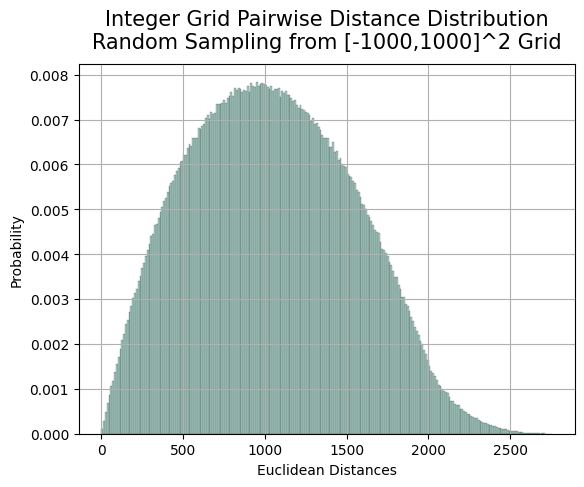

In [99]:
sns.histplot(all_distances, color='#8CBEB2', stat='probability')
plt.grid()
plt.title(f'Integer Grid Pairwise Distance Distribution\nRandom Sampling from [-{N},{N}]^2 Grid', fontsize=15, y=1.02)
plt.show()

### Database Buildup

In [15]:
def update_db(db, iris_df, db_size):
    db_current_size = db.get_stats()['db_size']
    assert (db_size - db_current_size) > 0
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for i, iris in enumerate(new_irises):
        print_progress(f'Updating DB to {int_to_scaled_string(db_size)}. Insertion progress: {(i+1)/len(new_irises):.1%}')
        db.insert(make_query(iris))
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

In [16]:
def numpy_array_to_iris_df(iris_array, mask_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(iris), list(mask)) for iris, mask in zip(iris_array, mask_array))
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

In [17]:
midpoints = np.load('noise_distribution_bin_midpoints.npz')['data']
probabilities = np.load('noise_distribution_probability_distribution.npz')['data']
def sample_noise(midpoints=midpoints, probabilities=probabilities, sample_size=1):
    return np.random.choice(midpoints, size=sample_size, p=probabilities)

In [18]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(read_num, *DIM), loaded_masks.reshape(read_num, *DIM))

In [19]:
# del db.lock
# save_pickle(db, f'db{int_to_scaled_string(read_num)}_M{M}_layer0.pkl')

### Noise analysis

In [20]:
# from threading import Lock
# db = load_pickle(f'db{int_to_scaled_string(read_num)}_M{M}.pkl')
# db.lock = Lock()

In [21]:
M = 32
noise_range = np.linspace(0,0.45,91)
num_experiments = 1000
K = 1

In [24]:
def run_experiment(db, iris_df, noise_level, M, K):
    random_iris = iris_df[iris_df['Inserted']].sample(1)['Template']
    random_target_id, iris = random_iris.index[0], random_iris.values[0]
    noisy_query = make_query(iris_with_noise(iris, noise_level=noise_level))
    res = db.search(noisy_query, K, ef=2*M)
    precision_by_node = any(random_target_id == tup[1] for tup in res)

    distances = [int_distance(vector, noisy_query[0]) for vector in db.vectors]
    idx_of_closest_vec = np.argmin(distances)
    precision_by_dist = any(idx_of_closest_vec == tup[1] for tup in res)
    noise_switched_closest = random_target_id == idx_of_closest_vec

    search_log = pd.DataFrame(db.search_log, index=['step', 'depth', 'eq', 'fq', 'lc', 'entry_point_id']).T.reset_index().rename(columns={'index':'node_id'})
    total_computations = len(search_log)
    computations_till_found = search_log['eq'].argmin() if precision_by_dist else np.nan
    
    return precision_by_node, precision_by_dist, noise_switched_closest, total_computations, computations_till_found

In [25]:
results_df_lst = []
for m_l in [M, M**8]:
    db = hnsw.HNSW(
        M=M, 
        efConstruction=M, 
        m_L=1/np.log(m_l), 
        distance_func=distance, 
        query_to_vector_func=query_to_vector
    )
    db.record_search_log = True
    iris_df['Inserted'] = False
    model_name = 'Regular' if m_l == M else 'Only Layer 0'
    update_db(db, iris_df, read_num)
    noise_results_df_lst = []
    for j, noise_level in enumerate(noise_range):
        print_progress(f'Evaluating {model_name} db. Noise progress: {(j+1)/(len(noise_range)+1):.1%}')
        
        results = (
            run_experiment(db, iris_df, noise_level, M, K
        ) for i in range(num_experiments))
        precision_by_node_lst, precision_by_dist_lst, noise_switched_closest_lst, total_computations_lst, computations_till_found_lst = zip(*results)

        noise_results_df_lst.append(
            pd.DataFrame(
                {'Total Steps':total_computations_lst, 'Steps Until Found':computations_till_found_lst}
            ).assign(
                precision_by_node = np.mean(precision_by_node_lst), 
                precision_by_dist = np.mean(precision_by_dist_lst),
                noise_switched_closest = np.mean(noise_switched_closest_lst),
                noise = noise_level
            )
        )
    results_df_lst.append(pd.concat(noise_results_df_lst).assign(Model = model_name))
results_df = pd.concat(results_df_lst)

Evaluating Only Layer 0 db. Noise progress: 98.9%                              

In [32]:
results_df.rename(columns={
    'precision_by_node':'Precision by Node',
    'precision_by_dist':'Precision by Distance',
    'noise_switched_closest':'Precentage of Unmatching Closest Node',
    'noise':'Noise Level',
}, inplace=True)

In [34]:
plot_df = results_df.melt(
    id_vars=['Model', 'Noise Level'], 
    value_vars=['Precision by Node', 'Precision by Distance', 'Precentage of Unmatching Closest Node'],
    var_name='Metric',
    value_name='Value'
)

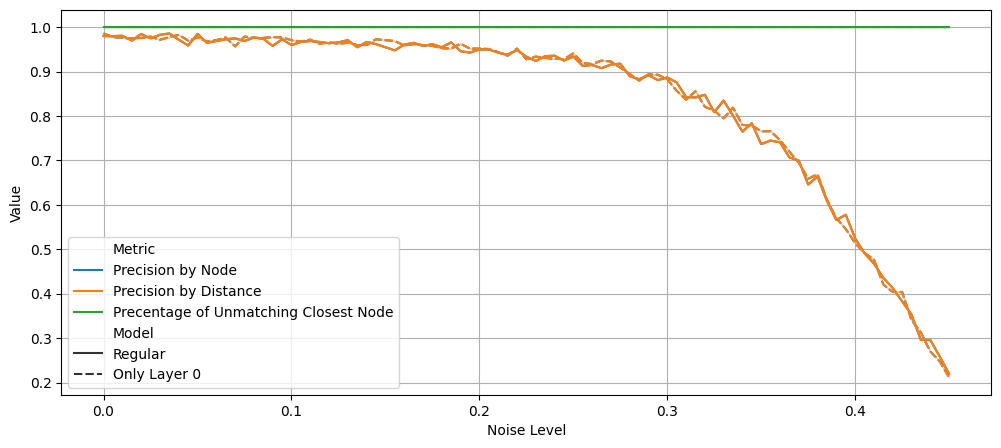

In [36]:
plt.figure(figsize=(12,5))
sns.lineplot(plot_df, x='Noise Level', y='Value', hue='Metric', style='Model')
plt.grid()
plt.show()

In [38]:
plot_df = results_df.melt(
    id_vars=['Model', 'Noise Level'], 
    value_vars=['Total Steps', 'Steps Until Found'],
    var_name='Measure',
    value_name='Amount of Steps'
)

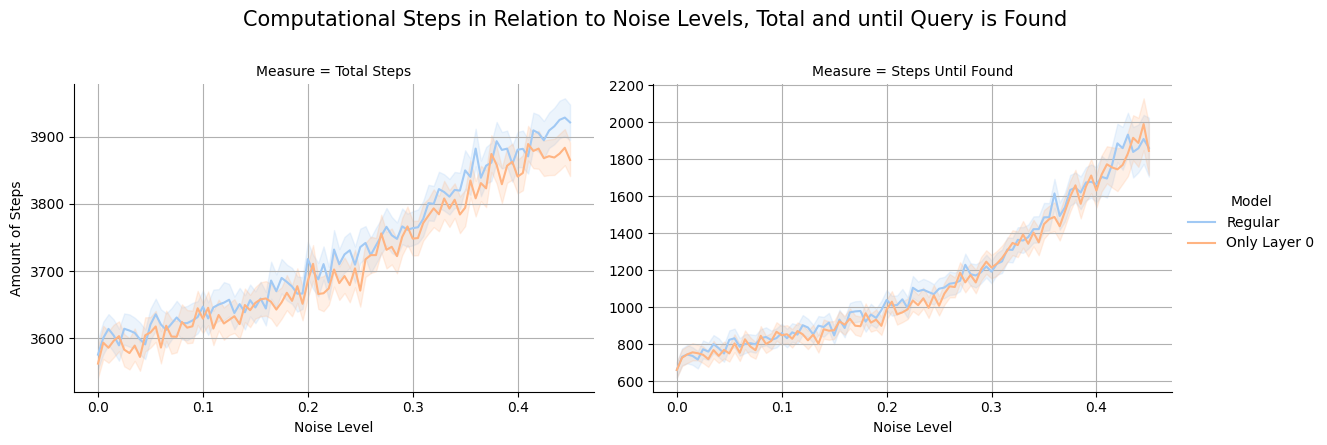

In [45]:
facetgrid = sns.FacetGrid(plot_df, col="Measure", hue='Model', palette='pastel', height=4, aspect=1.5, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x="Noise Level", y="Amount of Steps")
[ax.grid() for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle("Computational Steps in Relation to Noise Levels, Total and until Query is Found", fontsize=15, y=1.1)
facetgrid.add_legend()
plt.show()

In [ ]:
temp_df = results_df.groupby(['Model', 'Noise Level'])[['Total Steps', 'Steps Until Found']].mean().reset_index()
temp_df = pd.concat(
    [
        temp_df[temp_df['Model'] == col].drop(columns='Model').reset_index(drop=True) for col in temp_df['Model'].unique()
    ], axis=1, keys=temp_df['Model'].unique()
)

In [68]:
(temp_df[('Regular','Total Steps')] > temp_df[('Only Layer 0','Total Steps')]).mean()

0.8241758241758241

In [69]:
(temp_df[('Regular','Steps Until Found')] > temp_df[('Only Layer 0','Steps Until Found')]).mean()

0.6813186813186813

### Search analysis 

In [129]:
noise_level = 0.3
num_experiments = 1000
M = 64
db_size_range = np.arange(10000, 100001, 5000)

In [130]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(read_num, *DIM), loaded_masks.reshape(read_num, *DIM))
db = hnsw.HNSW(
    M=M, 
    efConstruction=M, 
    m_L=1/np.log(M**4), 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)
db.record_search_log = True

In [132]:
df_lst = []
for db_size in db_size_range:
    update_db(db, iris_df, db_size)
    precision_lst, total_computations_lst, computations_till_found_lst = [], [], []
    for i in range(num_experiments):
        print_progress(f'Current DB Size: {db_size}. Search progress: {(i+1)/num_experiments:.1%}')
        random_iris = iris_df[iris_df['Inserted']].sample(1)['Template']
        random_target_id, iris = random_iris.index[0], random_iris.values[0]
        noisy_query = make_query(iris_with_noise(iris, noise_level=noise_level))
        res = db.search(noisy_query, K, ef=2*M)
        precision_lst.append(any(random_target_id == tup[1] for tup in res))
        
        search_log = pd.DataFrame(db.search_log, index=['step', 'depth', 'eq', 'fq', 'lc', 'entry_point_id']).T.reset_index().rename(columns={'index':'node_id'})
        total_computations_lst.append(len(search_log))
        computations_till_found_lst.append(search_log['eq'].argmin())
        # search_log['total_num_steps'] = len(search_log)
        # search_log = search_log[search_log['step'] <= search_log['eq'].argmin()]
        # search_log['step'], search_log['depth'] = search_log['step'].astype(int), search_log['depth'].astype(int)
        # search_log['search_progress'] = search_log['eq'].cummin()
        # search_log['steps_progress'] = search_log['search_progress'].diff(periods=-1)
        # df_list.append(search_log.assign(experiment = i))
    df_lst.append(
        pd.DataFrame(
            {'Total Steps':total_computations_lst, 'Steps Until Found':computations_till_found_lst}
        ).assign(DB_Size = db_size, FNMR = 1 - np.mean(precision_lst))
    )
computation_df = pd.concat(df_lst)

Search progress: 100.0%                                                        

In [135]:
plot_df = (
    computation_df
    .rename(columns={'DB_Size':'DB Size'})
    .melt(id_vars='DB Size', value_vars=['Total Steps', 'Steps Until Found'], var_name='Metric', value_name='Steps')
)

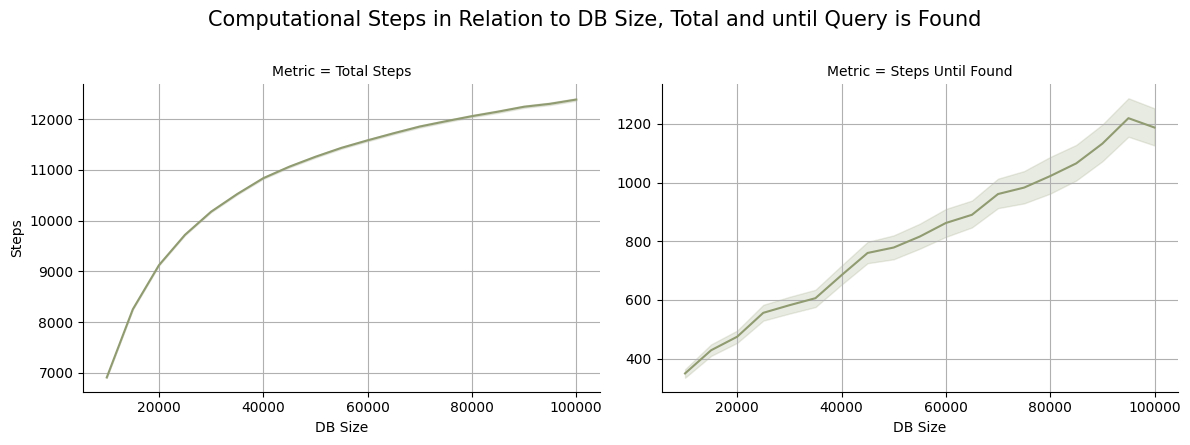

In [144]:
facetgrid = sns.FacetGrid(plot_df, col="Metric", height=4, aspect=1.5, sharey=False)
facetgrid.map_dataframe(sns.lineplot, x="DB Size", y="Steps", color='#909B71')
[ax.grid() for ax in facetgrid.axes.flat]
facetgrid.fig.suptitle("Computational Steps in Relation to DB Size, Total and until Query is Found", fontsize=15, y=1.1)
plt.show()

In [ ]:
# Create a 2x3 grid for the subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle(f'Results on {int_to_scaled_string(read_num)} database with M={M}, K={K}\nPrecision over {int_to_scaled_string(num_experiments)} experiments is {precision:.1%}', fontsize=20, y=1.03)

# Plot 1: Distribution of progress in each step
sns.histplot(final_df['steps_progress'].dropna(), stat='probability', color='#04BF8A', bins=15, ax=axes[0, 0])
axes[0, 0].set_title('G1 - Progress in each step (until found)', fontsize=15, y=1.03)
bin_heights, bin_edges = np.histogram(final_df['steps_progress'].dropna(), bins=15, density=True)
bin_heights = bin_heights / bin_heights.sum()
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
for i in range(len(bin_heights)):
    if bin_heights[i] > 0:  # Only label non-zero bins
        height = bin_heights[i]
        axes[0, 0].text(bin_centers[i], height, f'{height:.2%}', ha='center', va='bottom', fontsize=6)
axes[0, 0].set_xlabel('Hamming Distance')

# Plot 2: Random examples of progress based on distance from the target
mask = final_df['experiment'].isin(np.random.randint(num_experiments, size=100))
sns.lineplot(final_df[mask], x='step', y='search_progress', estimator=None, units='experiment', color='#025940', ax=axes[0, 1])
axes[0, 1].set_title('G2 - Random examples of progress by distance from target', fontsize=15, y=1.03)
axes[0, 1].set_xlabel('Steps')
axes[0, 1].set_ylabel('Hamming Distance')

# # Plot 3: Total progress distribution across layers
# temp = final_df.groupby(['experiment', 'layer'])['steps_progress'].sum().reset_index()
# sns.histplot(temp, x='steps_progress', hue='layer', palette='Set2', bins=100, ax=axes[0, 2])
# axes[0, 2].set_title('G3 - Total progress distribution by layer', fontsize=15, y=1.03)
# axes[0, 2].set_xlabel('Hamming Distance')

# Plot 4: Distribution of total steps performed by the algorithm
sns.histplot(final_df.groupby('experiment')['total_num_steps'].first(), stat='probability', color='#026873', ax=axes[1, 0])
axes[1, 0].set_title('G4 - Total amount of steps the algorithm performs (during search)', fontsize=15, y=1.03)
axes[1, 0].set_xlabel('Steps')

# Plot 5: Distribution of steps until the target is found
sns.histplot(final_df.groupby('experiment')['step'].max(), color='#024059', stat='probability', ax=axes[1, 1])
axes[1, 1].set_title('G5 - Amount of steps until sample is found', fontsize=15, y=1.03)
axes[1, 1].set_xlabel('Steps')

# # Plot 6: Depth changes relative to the layer
# final_df['depth'] = np.where(final_df['depth'] == 0, 1, final_df['depth'])
# temp = final_df.groupby(['experiment', 'layer'])['depth'].nunique().reset_index()
# sns.histplot(temp, x='depth', hue='layer', bins=20, stat='probability', palette='Set2')
# axes[1, 2].set_title('G6 - Depth change in relation to layer', fontsize=15, y=1.03)
# axes[1, 2].set_xlabel('Depth')

# Adjust the layout so titles and labels don't overlap
plt.tight_layout()

# Show the figure
plt.show()

In [ ]:
sns.histplot(edge_weight_distribution, x='Edge Distances', hue='Layer', palette='husl', stat='probability')